In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")


function for df generation 

In [3]:
def df_generator(df_exp_data, df_num_data, binding_site):

    num_muts = []
    num_mut_sites = [] 
    binding_site_idx = [] 
    for mut in df_num_data["mutations"].to_numpy():
        num_muts.append(mut.split("_")[0])
        num_mut_sites.append(int(mut.split("_")[0][1:-1])) #just get numerical value
    sorting_idx = np.argsort(num_mut_sites)
    num_muts = np.array(num_muts)[sorting_idx] #just sort by binding site 
    for mut in binding_site : 
        binding_site_idx.append(np.where(num_muts == mut )[0] [0]) 

    exp_muts_np = df_exp_data["mutation"].to_numpy()
    idx= []  
    for mut in num_muts : 
        idx.append(np.where(exp_muts_np == mut )[0] [0]) 
    if np.all(exp_muts_np[idx] == num_muts) == False :      #check here
        print("Error, mutations do not match")
        
    relevant_exp_data = df_exp_data.iloc[idx]["bind_avg"].to_numpy()
    R = 1.98*1e-3 #1e-3 for cal to kcal conversion 
    T =298  #room temp  
    K_D_app = 3.9*1e-11 #from paper 
    delta_g_deg = R * T * np.log(K_D_app)
    tmp_K_mut = 10**(relevant_exp_data) * K_D_app
    delta_g_first_method = -R * T * np.log(tmp_K_mut)

    del_del_g_total = - ( delta_g_deg + delta_g_first_method) 

    df_num_data_sorted= df_num_data.iloc[sorting_idx].copy()
    df_num_data_sorted["exp_data"] = del_del_g_total
    df_num_data_sorted["mutations"] = num_muts
    df_num_data_sorted_binding_site = df_num_data_sorted.iloc[binding_site_idx].copy()
    
        
    #non_binding_df
    mask =np.ones(len(num_muts), dtype=bool)
    mask[binding_site_idx] = 0 #mask the binding site. 
    non_binding_idx = sorting_idx[mask]
    df_num_data_sorted_no_binding_site = df_num_data.iloc[non_binding_idx].copy()
    df_num_data_sorted_no_binding_site["exp_data"] = del_del_g_total[mask]
    df_num_data_sorted_no_binding_site["mutations"] = num_muts[mask]


    return df_num_data_sorted, df_num_data_sorted_binding_site, \
        df_num_data_sorted_no_binding_site,binding_site_idx

binding site dec

In [4]:
binding_site =np.array( ['K417A', 'N439A', 'Y449A', 'Y453A', 'L455A', 'F456A',
       'F486A', 'N487A', 'Y489A', 'Q493A', 'S494A', 'Q498A',
       'T500A', 'N501A', 'V503A', 'Y505A'])

Mbdoni resutls 

In [5]:
df_exp_data = pd.read_csv("single_mut_effects.csv")
df_num_data_mbondi = pd.read_csv("all_amino_pb_gb_gb66.csv", index_col=0)
df_num_data_sorted_mbondi, df_num_data_sorted_binding_site_mbondi, \
    df_num_data_sorted_no_binding_site_mbondi, binding_site_idx = \
    df_generator(df_exp_data, df_num_data_mbondi, binding_site)

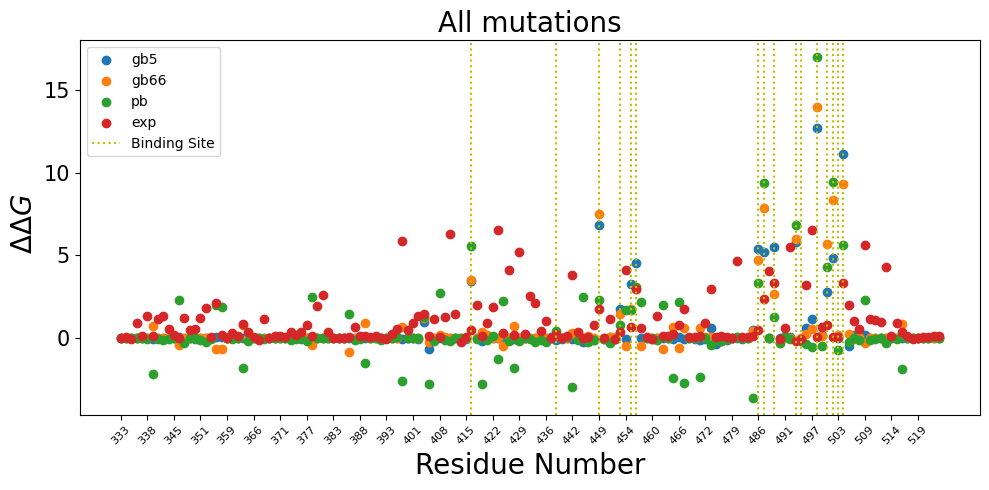

In [18]:
plt.figure(figsize=(10, 5))
plt.scatter( df_num_data_sorted_mbondi["mutations"]
            ,-df_num_data_sorted_mbondi["delta_delta_g_gen"], label="gb5")
plt.scatter( df_num_data_sorted_mbondi["mutations"]
            ,-df_num_data_sorted_mbondi["delta_delta_g_gen_66"], label="gb66")
plt.scatter( df_num_data_sorted_mbondi["mutations"]
            ,-df_num_data_sorted_mbondi["delta_delta_g_pb"], label="pb")
plt.scatter( df_num_data_sorted_mbondi["mutations"]
            ,-df_num_data_sorted_mbondi["exp_data"], label="exp")
            


tick_positions = np.arange(0, len(df_num_data_sorted_mbondi["mutations"]), 5)
tick_labels = [df_num_data_sorted_mbondi["mutations"].iloc[pos] for pos in tick_positions]

tick_labels = [df_num_data_sorted_mbondi["mutations"].iloc[pos][1:-1] for pos in tick_positions]
plt.xticks(tick_positions, tick_labels,rotation=45,  fontsize = 8)
plt.xlabel("Residue Number", fontsize = 20)
plt.yticks(fontsize= 15)
for true_idx , idx in enumerate(binding_site_idx):
    if binding_site_idx[true_idx] == binding_site_idx[-1] : #for the last one
        plt.axvline(x=idx, color='y', linestyle=':', label = "Binding Site")
    else:
        plt.axvline(x=idx, color='y', linestyle=':')
    

plt.legend()
plt.title("All mutations", fontsize = 20)
plt.ylabel(" $\Delta \Delta G$", fontsize = 20)
plt.tight_layout()
plt.savefig("all_muts_fig.png")

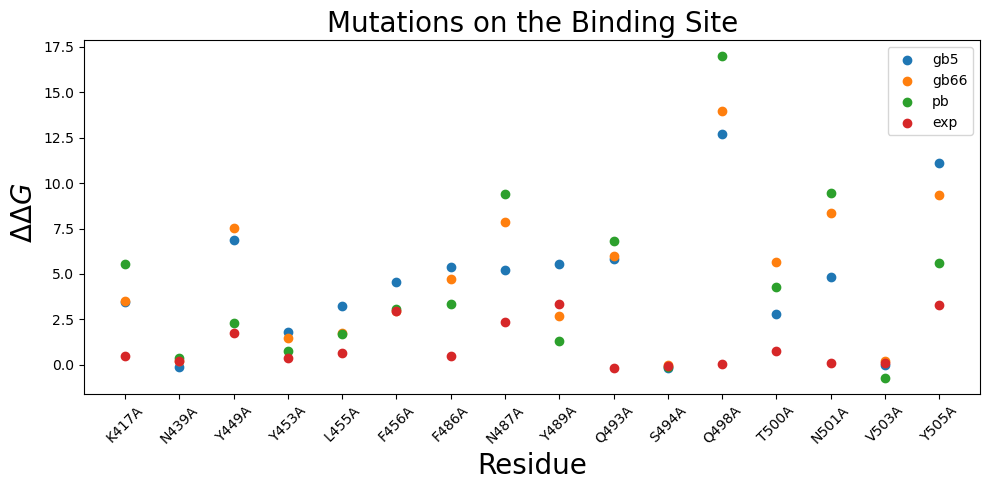

In [7]:
plt.figure(figsize=(10, 5))

plt.scatter( df_num_data_sorted_binding_site_mbondi["mutations"]
            ,-df_num_data_sorted_binding_site_mbondi["delta_delta_g_gen"], label="gb5")
plt.scatter( df_num_data_sorted_binding_site_mbondi["mutations"]
            ,-df_num_data_sorted_binding_site_mbondi["delta_delta_g_gen_66"], label="gb66")
plt.scatter( df_num_data_sorted_binding_site_mbondi["mutations"]
            ,-df_num_data_sorted_binding_site_mbondi["delta_delta_g_pb"], label="pb")
plt.scatter( df_num_data_sorted_binding_site_mbondi["mutations"]
            ,-df_num_data_sorted_binding_site_mbondi["exp_data"], label="exp")
            
plt.legend()
plt.title("Mutations on the Binding Site", fontsize = 20)
plt.ylabel(" $\Delta \Delta G$", fontsize = 20)
plt.xticks(rotation=45)
plt.xlabel("Residue",  fontsize = 20)
plt.tight_layout()
plt.savefig("binding_site_fig.png")

In [8]:


window_size = 3
moving_average = np.convolve(-df_num_data_sorted_mbondi["delta_delta_g_gen"], np.ones(window_size)/window_size, mode='valid')


In [9]:
len(df_num_data_sorted_mbondi["mutations"])

155

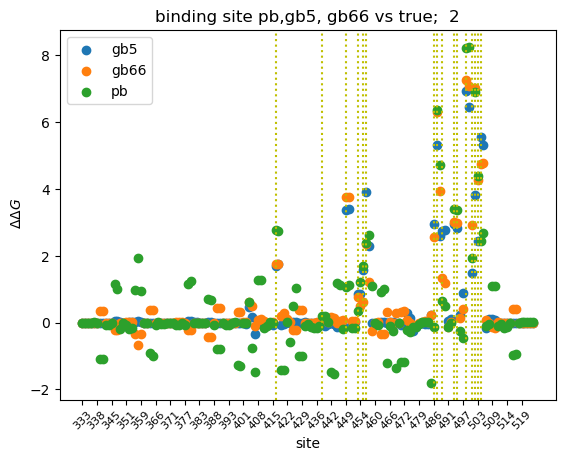

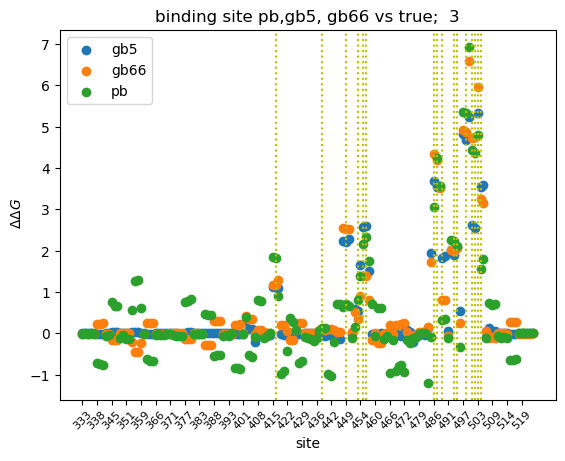

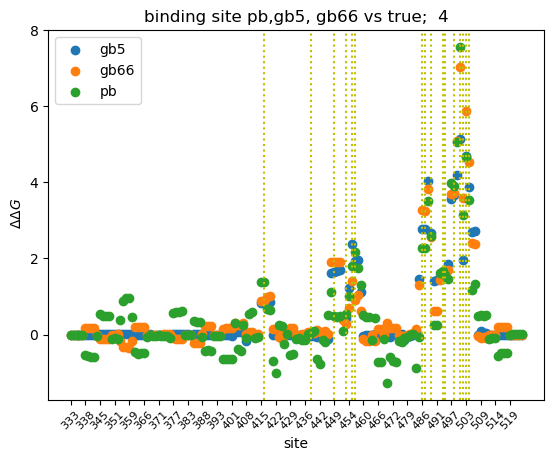

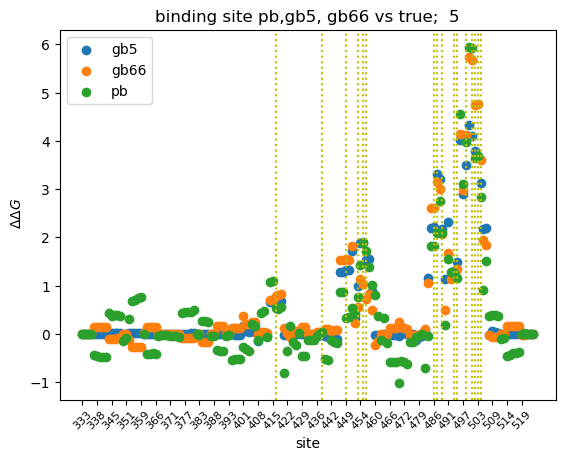

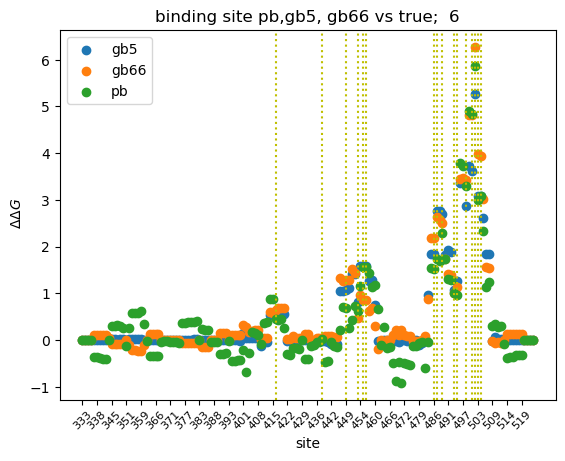

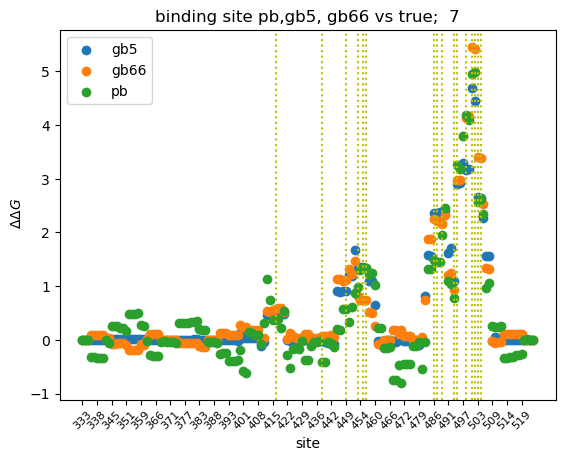

In [10]:
window_sizes = [2, 3, 4, 5, 6, 7]
for window_size in window_sizes : 
    
    moving_average_g_gen = np.convolve(-df_num_data_sorted_mbondi["delta_delta_g_gen"],\
        np.ones(window_size)/window_size, mode='same')

    moving_average_g_gen_66 = np.convolve(-df_num_data_sorted_mbondi["delta_delta_g_gen_66"],\
        np.ones(window_size)/window_size, mode='same')
  
    moving_average_pb = np.convolve(-df_num_data_sorted_mbondi["delta_delta_g_pb"],\
        np.ones(window_size)/window_size, mode='same')
    
    plt.figure()
    plt.scatter( df_num_data_sorted_mbondi["mutations"]
                ,moving_average_g_gen, label="gb5")
    plt.scatter( df_num_data_sorted_mbondi["mutations"]
                ,moving_average_g_gen_66, label="gb66")
    plt.scatter( df_num_data_sorted_mbondi["mutations"]
                ,moving_average_pb, label="pb")
    # plt.scatter( df_num_data_sorted_mbondi["mutations"]
    #             ,-df_num_data_sorted_mbondi["exp_data"], label="exp")
             
    plt.legend()
    plt.title(f"binding site pb,gb5, gb66 vs true;  {window_size}")
    plt.ylabel(" $\Delta \Delta G$")

    tick_positions = np.arange(0, len(df_num_data_sorted_mbondi["mutations"]), 5)
    tick_labels = [df_num_data_sorted_mbondi["mutations"].iloc[pos] for pos in tick_positions]

    tick_labels = [df_num_data_sorted_mbondi["mutations"].iloc[pos][1:-1] for pos in tick_positions]
    plt.xticks(tick_positions, tick_labels,rotation=45,  fontsize = 8)
    plt.xlabel("site")

    for idx in binding_site_idx:
        plt.axvline(x=idx, color='y', linestyle=':')
        
#moving_average_g_gen, moving_average_g_gen_66, moving_average_pb

correlation stuff

In [11]:

col_names= ["gb5","gb66", "pb" , "exp"]

all_data = np.vstack((-df_num_data_sorted_mbondi["delta_delta_g_gen"],
          -df_num_data_sorted_mbondi["delta_delta_g_gen_66"],
          -df_num_data_sorted_mbondi["delta_delta_g_pb"],
          -df_num_data_sorted_mbondi["exp_data"]
          )).T


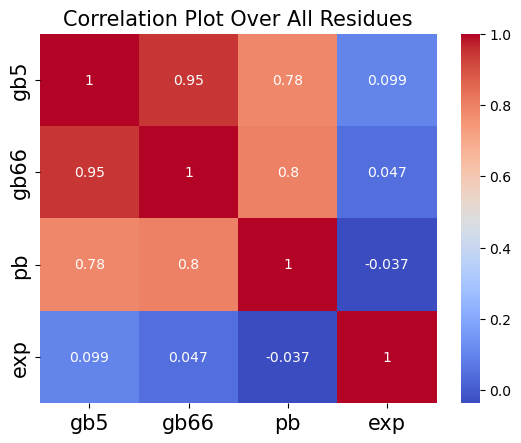

In [12]:

corr = np.corrcoef(all_data, rowvar=False)
sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=col_names, yticklabels=col_names)
plt.title('Correlation Plot Over All Residues', fontsize=15)
plt.xticks(fontsize= 15 )
plt.yticks(fontsize= 15 )
plt.savefig("corr_all_muts.png")

corr stuff on binding site

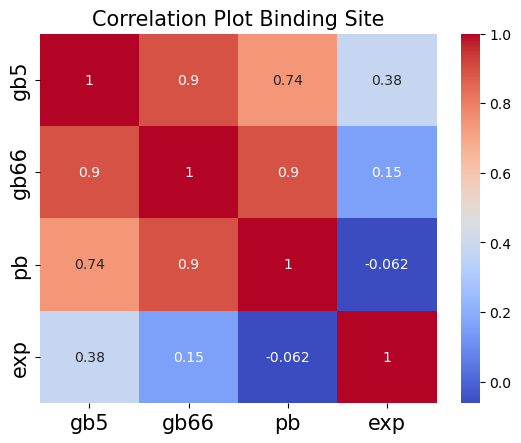

In [13]:
col_names= ["gb5","gb66", "pb" , "exp"]
all_data = np.vstack((-df_num_data_sorted_binding_site_mbondi["delta_delta_g_gen"],
          -df_num_data_sorted_binding_site_mbondi["delta_delta_g_gen_66"],
          -df_num_data_sorted_binding_site_mbondi["delta_delta_g_pb"],
          -df_num_data_sorted_binding_site_mbondi["exp_data"]
          )).T
corr = np.corrcoef(all_data, rowvar=False)
sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=col_names, yticklabels=col_names)
plt.title('Correlation Plot Binding Site', fontsize=15)
plt.xticks(fontsize= 15 )
plt.yticks(fontsize= 15 )
plt.savefig("corr_binding_site.png")

histogram stuff

<Figure size 640x480 with 0 Axes>

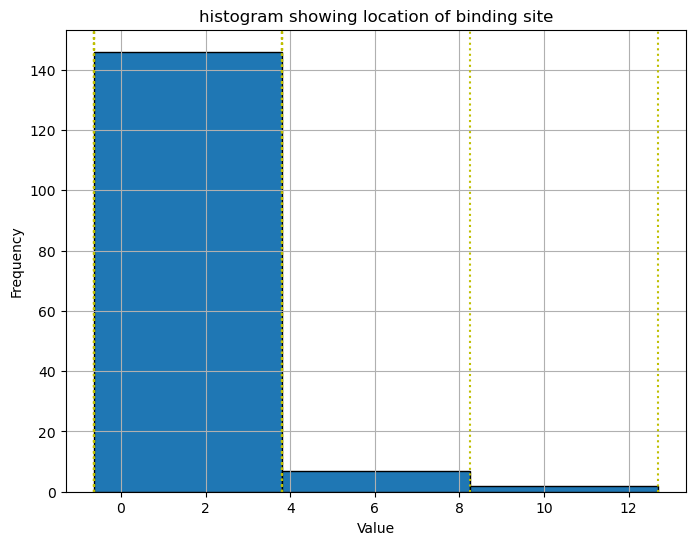

In [14]:
bin_arr = np.arange(3, 5, 5)
for num_bins in bin_arr:
    plt.figure()
    data = -df_num_data_sorted_mbondi["delta_delta_g_gen"]  
    binding_site_data = -df_num_data_sorted_binding_site_mbondi["delta_delta_g_gen"]
    # Compute histogram
    counts, bins = np.histogram(data, bins=num_bins)
    # Find indices of values in each bin
    indices = np.digitize(data, bins)
    binding_site_indices = np.digitize(binding_site_data, bins)
    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=bins, edgecolor='black')  # Plot histogram with specified bins
    plt.title('histogram showing location of binding site')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    for idx in binding_site_indices:
        plt.axvline(x=bins[idx-1], color='y', linestyle=':')
    plt.grid(True)
    plt.show()

    binding_site_indices



clustering stuff (pretty much just hist)

In [15]:
def smple_clust(col,  df_num_data_sorted, df_num_data_sorted_binding_site , \
        df_num_data_sorted_no_binding_site,binding_site_idx, num_clust = 4, plot_command = 0,) : 
        
        all_sites_data          =       -df_num_data_sorted[col]
        binding_site_data       =       -df_num_data_sorted_binding_site[col]
        non_binding_site        =       -df_num_data_sorted_no_binding_site[col]
        
        
        gb5_dat = all_sites_data.to_numpy() 
        # Reshape data for KMeans input (reshape to 2D array)
        gb5_dat_reshape = gb5_dat.reshape(-1, 1)
        # Apply K-means clustering
        kmeans = KMeans(n_clusters=num_clust, random_state=0)
        labels = kmeans.fit_predict(gb5_dat_reshape)
        
        #binding site
        zero_clust_idx = abs(kmeans.cluster_centers_).argmin() #near zero val 
        binding_site_dat = binding_site_data.to_numpy()
        dat_reshape_binding_site = binding_site_dat.reshape(-1, 1)
        labels_binding_site = kmeans.predict(dat_reshape_binding_site)
        model_accuracy = (len(labels_binding_site[labels_binding_site != zero_clust_idx]))\
                /(len(labels_binding_site)) *100
        
        #non_binding site
        non_binding_site_dat = non_binding_site.to_numpy()
        dat_reshape_non_binding_site = non_binding_site_dat.reshape(-1, 1)
        labels_non_binding_site = kmeans.predict(dat_reshape_non_binding_site)
        model_accuracy_FP = (len(labels_non_binding_site[labels_non_binding_site == zero_clust_idx]))\
                /(len(labels_non_binding_site)) *100
        
        non_binding_site
        
        
        if plot_command == 1 :
                #title stuff
                tmp_col = col.split("delta")
                if len(tmp_col) >1 :
                        title_str = (col.split("delta")[-1][1:])
                else:
                        title_str = (col.split("_")[0])
                # Plotting the clusters
                plt.figure(figsize=(8, 6))
                plt.scatter(df_num_data_sorted_mbondi["mutations"], gb5_dat, c=labels, s=50, cmap='viridis')
                plt.ylabel('ddg')
                #to show binding site values
                tick_positions = np.arange(0, len(df_num_data_sorted["mutations"]), 5)
                tick_labels = [df_num_data_sorted_mbondi["mutations"].iloc[pos][1:-1] for pos in tick_positions]
                plt.xticks(tick_positions, tick_labels,rotation=45,  fontsize = 8)
                plt.xlabel("site")
                for idx in binding_site_idx:
                        plt.axvline(x=idx, color='y', linestyle=':')
                plt.title(f'K-means Clustering {title_str}; {model_accuracy}')
                plt.show()

        return model_accuracy, model_accuracy_FP, num_clust

arr of all cols

In [16]:
cols_to_test = ["delta_delta_g_gen","delta_delta_g_gen_66","delta_delta_g_pb","exp_data"]

In [17]:
random_state=0 
print(f"{'Model':<25} {'true pos%' :<10}  {'false pos%':<10} {'num_clust':<10}")
num_clust_arr = [2,3,4,5,6,7]
for num_clust in num_clust_arr : 
    for col in cols_to_test :
        model_accuracy, model_accuracy_FP, num_clust_out = smple_clust(col, \
            df_num_data_sorted_mbondi, df_num_data_sorted_binding_site_mbondi , \
                df_num_data_sorted_no_binding_site_mbondi, binding_site_idx, \
                    num_clust=num_clust)
        print(f"{col:<25}: {model_accuracy:<10.4}: {model_accuracy_FP:<10.4} : {num_clust_out}")
    print("-----------------------------------------------------")

Model                     true pos%   false pos% num_clust 
delta_delta_g_gen        : 68.75     : 100.0      : 2
delta_delta_g_gen_66     : 50.0      : 100.0      : 2
delta_delta_g_pb         : 37.5      : 100.0      : 2
exp_data                 : 18.75     : 87.77      : 2
-----------------------------------------------------
delta_delta_g_gen        : 75.0      : 100.0      : 3
delta_delta_g_gen_66     : 68.75     : 100.0      : 3
delta_delta_g_pb         : 75.0      : 89.93      : 3
exp_data                 : 31.25     : 69.78      : 3
-----------------------------------------------------
delta_delta_g_gen        : 81.25     : 100.0      : 4
delta_delta_g_gen_66     : 75.0      : 100.0      : 4
delta_delta_g_pb         : 75.0      : 89.93      : 4
exp_data                 : 37.5      : 62.59      : 4
-----------------------------------------------------
delta_delta_g_gen        : 81.25     : 97.12      : 5
delta_delta_g_gen_66     : 81.25     : 100.0      : 5
delta_delta_g_pb      